# Jaguar Re-Identification

## Score: 

In [16]:
import os
import math
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler
from torch.cuda.amp import GradScaler, autocast

import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2

def seed_everything(seed=80085):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [17]:
# =============================================================================
# CONFIG
# =============================================================================
class CFG:
    data_dir = Path('jaguar-re-id')
    train_csv = data_dir / 'train.csv'
    test_csv = data_dir / 'test.csv'
    train_dir = data_dir / 'train' / 'train'
    test_dir = data_dir / 'test' / 'test'
    
    backbone = 'convnext_base.fb_in22k_ft_in1k'
    image_size = 384
    num_classes = 31
    
    epochs = 30
    batch_size = 16
    lr = 1e-4
    weight_decay = 0.01
    warmup_epochs = 2
    
    arcface_s = 30.0
    arcface_m = 0.5
    
    use_tta = True
    num_workers = 0
    mixed_precision = True

Train: 1895 | Test pairs: 137270 | Classes: 31


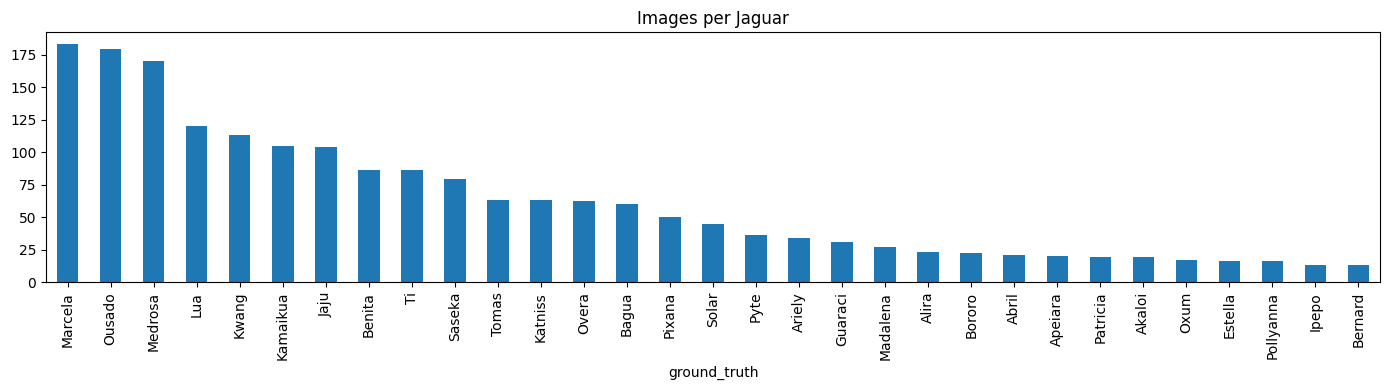

In [18]:
# =============================================================================
# DATA
# =============================================================================
train_df = pd.read_csv(CFG.train_csv)
test_df = pd.read_csv(CFG.test_csv)

print(f"Train: {len(train_df)} | Test pairs: {len(test_df)} | Classes: {train_df['ground_truth'].nunique()}")

class_counts = train_df['ground_truth'].value_counts()
plt.figure(figsize=(14, 4))
class_counts.plot(kind='bar')
plt.title('Images per Jaguar')
plt.tight_layout()
plt.show()

In [19]:
# =============================================================================
# TRANSFORMS
# =============================================================================
def get_train_transforms():
    return A.Compose([
        A.LongestMaxSize(max_size=CFG.image_size),
        A.PadIfNeeded(CFG.image_size, CFG.image_size, border_mode=0),
        A.HorizontalFlip(p=0.5),
        A.Affine(scale=(0.85, 1.15), rotate=(-15, 15), shear=(-10, 10), p=0.5),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
        A.GaussNoise(std_range=(0.01, 0.05), p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

def get_test_transforms(flip=False):
    transforms = [
        A.LongestMaxSize(max_size=CFG.image_size),
        A.PadIfNeeded(CFG.image_size, CFG.image_size, border_mode=0),
    ]
    if flip:
        transforms.append(A.HorizontalFlip(p=1.0))
    transforms.extend([
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])
    return A.Compose(transforms)

In [20]:
# =============================================================================
# DATASET
# =============================================================================
class JaguarDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = Path(img_dir)
        self.transform = transform
        unique_labels = sorted(df['ground_truth'].unique())
        self.label_encoder = {name: idx for idx, name in enumerate(unique_labels)}
        self.labels = np.array([self.label_encoder[gt] for gt in df['ground_truth']])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = np.array(Image.open(self.img_dir / row['filename']).convert('RGB'))
        if self.transform:
            image = self.transform(image=image)['image']
        return image, self.labels[idx]


class JaguarTestDataset(Dataset):
    def __init__(self, image_files, img_dir, transform=None):
        self.image_files = image_files
        self.img_dir = Path(img_dir)
        self.transform = transform
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        filename = self.image_files[idx]
        image = np.array(Image.open(self.img_dir / filename).convert('RGB'))
        if self.transform:
            image = self.transform(image=image)['image']
        return image, filename


class BalancedSampler(Sampler):
    def __init__(self, labels, samples_per_class=80):
        self.class_indices = {}
        for idx, label in enumerate(labels):
            if label not in self.class_indices:
                self.class_indices[label] = []
            self.class_indices[label].append(idx)
        self.samples_per_class = samples_per_class
        self.total_samples = len(self.class_indices) * self.samples_per_class
        
    def __iter__(self):
        indices = []
        for cls_indices in self.class_indices.values():
            selected = np.random.choice(cls_indices, self.samples_per_class, replace=len(cls_indices) < self.samples_per_class)
            indices.extend(selected)
        np.random.shuffle(indices)
        return iter(indices)
    
    def __len__(self):
        return self.total_samples

In [21]:
# =============================================================================
# MODEL
# =============================================================================
class ArcFaceLoss(nn.Module):
    def __init__(self, num_classes, embedding_dim, s=30.0, m=0.5):
        super().__init__()
        self.s, self.m = s, m
        self.weight = nn.Parameter(torch.FloatTensor(num_classes, embedding_dim))
        nn.init.xavier_uniform_(self.weight)
        self.cos_m, self.sin_m = math.cos(m), math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m
        
    def forward(self, embeddings, labels):
        embeddings = F.normalize(embeddings, p=2, dim=1)
        weight = F.normalize(self.weight, p=2, dim=1)
        cosine = F.linear(embeddings, weight)
        sine = torch.sqrt(1.0 - torch.clamp(cosine ** 2, 0, 1))
        phi = cosine * self.cos_m - sine * self.sin_m
        phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = torch.zeros_like(cosine).scatter_(1, labels.view(-1, 1).long(), 1)
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        return F.cross_entropy(output * self.s, labels)


class JaguarModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model(CFG.backbone, pretrained=True, num_classes=0)
        self.embedding_dim = self.backbone.num_features
        self.arcface = ArcFaceLoss(CFG.num_classes, self.embedding_dim, CFG.arcface_s, CFG.arcface_m)
        print(f"Loaded {CFG.backbone} | Embedding: {self.embedding_dim} | Params: {sum(p.numel() for p in self.parameters()):,}")
        
    def forward(self, x, labels=None):
        emb = F.normalize(self.backbone(x), p=2, dim=1)
        if labels is not None:
            return emb, self.arcface(emb, labels)
        return emb

In [22]:
# =============================================================================
# TRAINING
# =============================================================================
train_dataset = JaguarDataset(train_df, CFG.train_dir, transform=get_train_transforms())
train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, sampler=BalancedSampler(train_dataset.labels), 
                          num_workers=CFG.num_workers, pin_memory=True)

model = JaguarModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=CFG.lr, total_steps=len(train_loader) * CFG.epochs,
                                                 pct_start=CFG.warmup_epochs / CFG.epochs)
scaler = GradScaler() if CFG.mixed_precision else None

best_loss = float('inf')
for epoch in range(CFG.epochs):
    model.train()
    total_loss = 0
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{CFG.epochs}')
    
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        if CFG.mixed_precision:
            with autocast():
                _, loss = model(images, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            _, loss = model(images, labels)
            loss.backward()
            optimizer.step()
        
        scheduler.step()
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} Loss: {avg_loss:.4f}")
    
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Saved best model")

print(f"\nTraining complete. Best loss: {best_loss:.4f}")

Loaded hf-hub:BVRA/MegaDescriptor-L-384 | Embedding: 1536 | Params: 195,246,132


C:\Users\ol1v3_7dwns5u\AppData\Local\Temp\ipykernel_55740\3029805447.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if CFG.mixed_precision else None


Epoch 1/40:   0%|          | 0/155 [00:00<?, ?it/s]

C:\Users\ol1v3_7dwns5u\AppData\Local\Temp\ipykernel_55740\3029805447.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ol1v3_7dwns5u\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# =============================================================================
# INFERENCE
# =============================================================================
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

unique_images = sorted(set(test_df['query_image']) | set(test_df['gallery_image']))
print(f"Extracting embeddings for {len(unique_images)} test images...")

def extract_embeddings(transform):
    dataset = JaguarTestDataset(unique_images, CFG.test_dir, transform=transform)
    loader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=CFG.num_workers)
    emb_dict = {}
    with torch.no_grad():
        for images, filenames in tqdm(loader, desc='Extracting', leave=False):
            emb = model(images.to(device))
            for fname, e in zip(filenames, emb):
                emb_dict[fname] = e.cpu().numpy()
    return emb_dict

if CFG.use_tta:
    print("TTA enabled")
    emb_original = extract_embeddings(get_test_transforms(flip=False))
    emb_flipped = extract_embeddings(get_test_transforms(flip=True))
    
    embeddings_dict = {}
    for fname in unique_images:
        avg_emb = (emb_original[fname] + emb_flipped[fname]) / 2
        embeddings_dict[fname] = avg_emb / np.linalg.norm(avg_emb)
else:
    embeddings_dict = extract_embeddings(get_test_transforms(flip=False))

print("Computing similarities...")
similarities = []
for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    sim = np.dot(embeddings_dict[row['query_image']], embeddings_dict[row['gallery_image']])
    similarities.append((sim + 1) / 2)

submission = pd.DataFrame({'row_id': test_df['row_id'], 'similarity': similarities})
submission.to_csv('submission.csv', index=False)

print(f"\nSubmission saved: submission.csv")
print(f"Rows: {len(submission)} | Mean: {submission['similarity'].mean():.4f} | Std: {submission['similarity'].std():.4f}")

Extracting embeddings for 371 test images...


Extracting:   0%|          | 0/24 [00:00<?, ?it/s]

Computing similarities for 137,270 pairs...


  0%|          | 0/137270 [00:00<?, ?it/s]


Submission saved: submission.csv
Rows: 137270 | Mean: 0.5110 | Std: 0.0973
